<a href="https://colab.research.google.com/github/iterat1on/class/blob/main/test_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pydicom
!pip install kornia
!pip install fastai --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 4.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 5.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 197 kB 5.0 MB/s 
     |████████████████████████████████| 60 kB 4.2 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"iterat1on","key":"fd9b26ce3c2bf39c4544405767fb1f48"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c unifesp-x-ray-body-part-classifier

100% 29.9G/29.9G [04:29<00:00, 144MB/s]
100% 29.9G/29.9G [04:29<00:00, 119MB/s]


In [ ]:
! unzip -qq unifesp-x-ray-body-part-classifier.zip

In [ ]:
import os
os.remove('unifesp-x-ray-body-part-classifier.zip')

In [ ]:
os.listdir()

['.config',
 'sample_submission.csv',
 'train.csv',
 'train',
 'kaggle.json',
 'test',
 'sample_data']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dpath = '/content/drive/MyDrive/Data/'

In [ ]:
import pandas as pd
train_merged_df = pd.read_csv(dpath+'train_merged_df.csv')
train_merged_df.head()

,MultiImageType,ImageType,ImageType1,InstanceCreationDate,InstanceCreationTime,SOPClassUID,SOPInstanceUID,StudyDate,SeriesDate,ContentDate,...,Lower Leg,Lumbar Spine,Others,Pelvis,Shoulder,Sinus,Skull,Thigh,Thoracic Spine,Wrist
0,1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,1.2.826.0.1.3680043.8.498.71157989004260882669...,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,1.2.826.0.1.3680043.8.498.32467620439025796224...,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,1.2.826.0.1.3680043.8.498.74856220852423198555...,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,1.2.826.0.1.3680043.8.498.90865692473901867788...,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,1.2.826.0.1.3680043.8.498.44687741644515558201...,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.medical.imaging import *

import pydicom, kornia, cv2

train_dcm_path = get_dicom_files("train")
test_dcm_path = get_dicom_files("test")

print("train len:", len(train_dcm_path), "\ntest len:", len(test_dcm_path))

train len: 1738 
test len: 743


/usr/local/lib/python3.7/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:239: UserWarning: The (0028,0101) 'Bits Stored' value (15-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({bits_stored}-bit) "


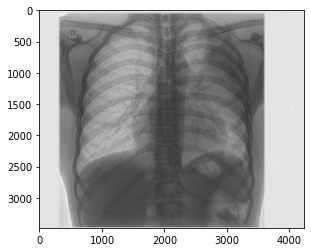

In [ ]:
tmp = train_dcm_path[np.random.randint(0, 1737)].dcmread()
dcm_img = tmp.pixel_array.astype(float)
img = np.uint8((np.maximum(dcm_img,0)/dcm_img.max())*255)
plt.imshow(img, cmap='gray')

In [ ]:
import cv2
from matplotlib import pyplot as plt

X = []
y = []
for i in range(len(train_dcm_path)):
    tmp = train_dcm_path[i].dcmread()
    
    dcm_img = tmp.pixel_array.astype(float)
    rescaled_img = np.uint8((np.maximum(dcm_img,0)/dcm_img.max())*255)
    image = cv2.resize(rescaled_img, dsize=(128,128), interpolation=cv2.INTER_AREA)/255 
    X.append(np.expand_dims(image,axis=-1))
    
    uid = str(tmp['SOPInstanceUID'].value)
    y.append(np.ndarray.flatten(np.array(train_merged_df.loc[train_merged_df['SOPInstanceUID'] == uid][train_merged_df.columns[64:]])))
    
X = np.array(X)
y = np.array(y)

/usr/local/lib/python3.7/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:239: UserWarning: The (0028,0101) 'Bits Stored' value (15-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({bits_stored}-bit) "
/usr/local/lib/python3.7/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:239: UserWarning: The (0028,0101) 'Bits Stored' value (10-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({bits_stored}-bit) "
/usr/local/lib/python3.7/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:239: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({bits_stored}-bit) "


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, Dropout, MaxPooling2D, Flatten, Dense

cnn_model = Sequential()
cnn_model.add(InputLayer(input_shape=(128,128,1)))
              
cnn_model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnn_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnn_model.add(MaxPooling2D((2, 2)))

cnn_model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnn_model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnn_model.add(MaxPooling2D((2, 2)))

cnn_model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnn_model.add(MaxPooling2D((2, 2)))

cnn_model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnn_model.add(MaxPooling2D((2, 2)))

cnn_model.add(Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnn_model.add(MaxPooling2D((2, 2)))

cnn_model.add(Flatten())
cnn_model.add(Dense(4096, activation="relu"))
cnn_model.add(Dense(2048, activation="relu"))
cnn_model.add(Dense(22, activation="sigmoid"))

cnn_model.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 128, 128, 64)      640       
                                                                 
 conv2d_42 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 conv2d_44 (Conv2D)          (None, 64, 64, 128)       147584    
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 32, 32, 128)      0         
 g2D)                                                

In [ ]:
history = cnn_model.fit(x = X_train,
                        y = y_train,
                        batch_size = 8,
                        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
                        validation_data = (X_val, y_val),
                        verbose = 1,
                        epochs = 20)

Epoch 1/20
176/176 [==============================] - 583s 3s/step - loss: 0.2032 - accuracy: 0.4307 - val_loss: 0.1477 - val_accuracy: 0.3949
Epoch 2/20
176/176 [==============================] - 583s 3s/step - loss: 0.1347 - accuracy: 0.4741 - val_loss: 0.1223 - val_accuracy: 0.4650
Epoch 3/20
176/176 [==============================] - 580s 3s/step - loss: 0.1180 - accuracy: 0.5139 - val_loss: 0.1072 - val_accuracy: 0.5605
Epoch 4/20
176/176 [==============================] - 583s 3s/step - loss: 0.1030 - accuracy: 0.5721 - val_loss: 0.1163 - val_accuracy: 0.5541
Epoch 5/20
176/176 [==============================] - 581s 3s/step - loss: 0.0888 - accuracy: 0.6340 - val_loss: 0.0923 - val_accuracy: 0.6306
Epoch 6/20
176/176 [==============================] - 584s 3s/step - loss: 0.0769 - accuracy: 0.6780 - val_loss: 0.0874 - val_accuracy: 0.6561
Epoch 7/20
176/176 [==============================] - 580s 3s/step - loss: 0.0653 - accuracy: 0.7278 - val_loss: 0.0873 - val_accuracy: 0.6433

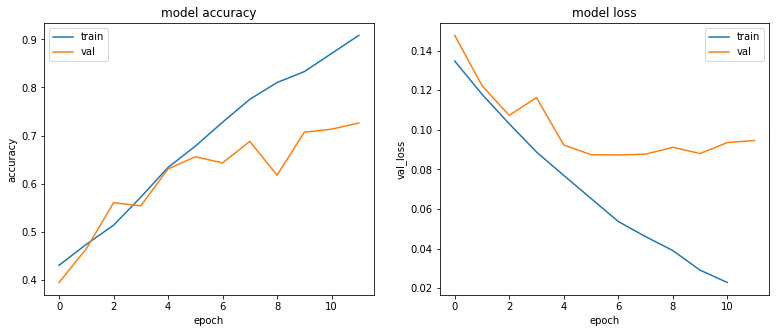

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13,5))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')

ax[1].plot(history.history['loss'][1:])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('val_loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper right')

fig.show()